# Classification based on leaves images

### Importing our own functions

In [1]:
import importlib

import src.Data as Data
importlib.reload(Data)
Data = Data.Data

import src.Metrics as Metrics
importlib.reload(Metrics)
Metrics = Metrics.Metrics

### Importing libraries
`numpy` and `pandas` are used to manipulate the data

`scikit-learn` is used to train the classification models and compute the metrics

`matplotlib` and `seaborn` are used to plot the results

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import LearningCurveDisplay, learning_curve, cross_validate, train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

### Loading the data
The data is loaded from the `data` folder.

Samples are split into a training set and a test set with a custom ratio. Stratified sampling is used to ensure that the proportion of samples in each class is the same in both sets.

Images are resized to a custom size so that all images have the same dimensions. Therefor, some leaves appear smaller than others.

In [3]:
data: Data = Data(test_size=0.2, include_images=True)

### Visualizing the data
Here are some examples of images in the dataset:

Leafs speacies from the dataset : 


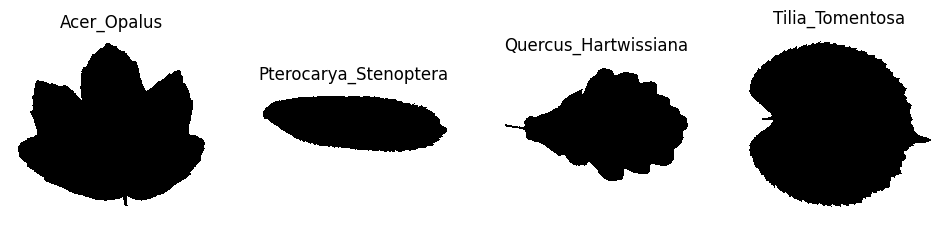

In [4]:
print('Leafs speacies from the dataset : ')
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for ax, image, label in zip(axes, data.x_image_tab, data.y_tab):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f'{label}')

### Choosing a model and training it

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Creating a classifier: a support vector classifier
classifiers = [
    # svm.SVC(),
    RandomForestClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1),
    # AdaBoostClassifier(),
    # GradientBoostingClassifier(),

]

# Fitting the classifier on the training set
for clf in classifiers:
    clf.fit(data.x_image_train, data.y_train)

# Predicting the species on the test set
predicted = [clf.predict(data.x_image_test) for clf in classifiers]

### Visualizing the predictions
To have a better idea of the performance of our models, we can show the predicted label and the ground truth on top of each image.

This is done for each model and combined in a single plot.

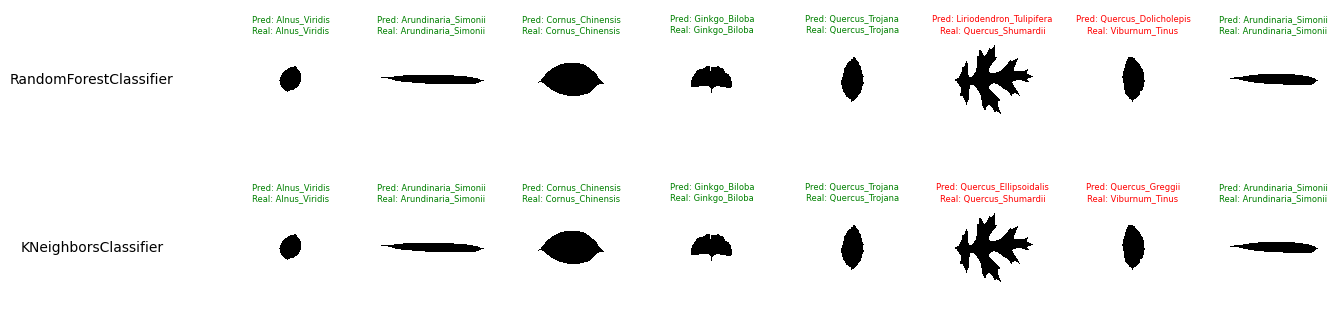

In [6]:
# Plotting the predictions and the ground truth on top of the images for each classifier
_, axes = plt.subplots(nrows=len(classifiers), ncols=9, figsize=(16, 2*len(classifiers)))
for i, clf in enumerate(classifiers):
    clf_name = clf.__class__.__name__
    for ax, image, prediction, actual_label in zip(axes[i][1:], data.x_image_test, predicted[i][:8], data.y_test):
        ax.set_axis_off()
        image = image.reshape(data.resized_images_width, data.resized_images_height)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        if prediction == actual_label:
            ax.set_title(f'Pred: {prediction}\nReal: {actual_label}', fontsize=6, color='green')
        else:
            ax.set_title(f'Pred: {prediction}\nReal: {actual_label}', fontsize=6, color='red')
    axes[i][0].set_axis_off()
    axes[i][0].text(0, 0.5, clf_name, fontsize=10, ha='center', va='center')


### Printing raw metrics for each class and each model

In [7]:
for i, clf in enumerate(classifiers):
    print(
        f"Classification report for classifier {clf}:\n"
        f"{metrics.classification_report(data.y_image_test, predicted[i])}\n"
    )

Classification report for classifier RandomForestClassifier(n_jobs=-1):
                              precision    recall  f1-score   support

             Acer_Capillipes       0.50      1.00      0.67         2
             Acer_Circinatum       0.67      1.00      0.80         2
                   Acer_Mono       1.00      1.00      1.00         2
                 Acer_Opalus       1.00      0.50      0.67         2
               Acer_Palmatum       1.00      1.00      1.00         2
                 Acer_Pictum       1.00      1.00      1.00         2
             Acer_Platanoids       1.00      1.00      1.00         2
                 Acer_Rubrum       0.33      0.50      0.40         2
              Acer_Rufinerve       0.67      1.00      0.80         2
            Acer_Saccharinum       0.00      0.00      0.00         2
               Alnus_Cordata       1.00      1.00      1.00         2
          Alnus_Maximowiczii       0.50      0.50      0.50         2
                 

### Plotting the metrics
To compare the performance of the classification models on images to those on features, we plot the same kind of bar charts.

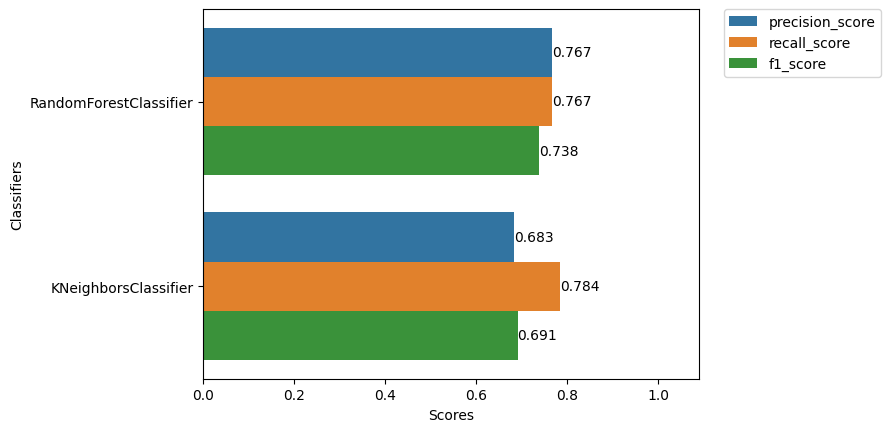

In [9]:
reports = [pd.DataFrame(metrics.classification_report(data.y_image_test, predicted[i], output_dict=True)).transpose() for i in range(len(classifiers))]

# Some targets are missing in the test set and due to this fact, the precision and recall are replaced by 0.
# So, we will remove them from the report.
for i, report in enumerate(reports):
    reports[i] = report[report['f1-score'] != 0]

# Storing the metrics of each classifier in a list of Metrics
metrics_list = []
for i, clf in enumerate(classifiers):
    clf_metrics = Metrics(clf.__class__.__name__)
    clf_metrics.add_metric('precision_score', reports[i]['precision'].mean())
    clf_metrics.add_metric('recall_score', reports[i]['recall'].mean())
    clf_metrics.add_metric('f1_score', reports[i]['f1-score'].mean())
    metrics_list.append(clf_metrics)

# Plotting the metrics as a barplot
Metrics.show_metrics_list(metrics_list)


### Visualizing the species with the worst F1-score

The leaf species with the worst f1-score are the following: 


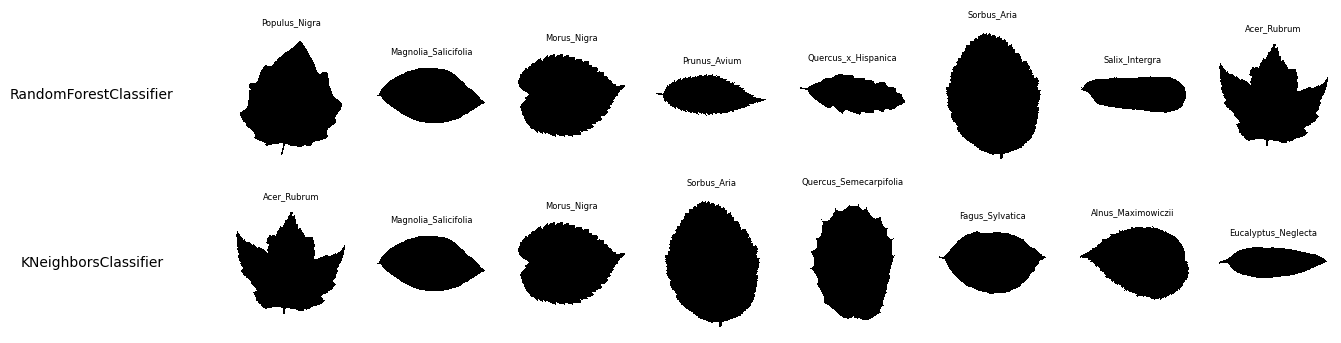

In [15]:
worst_leaf_names = [df.sort_values(by=['f1-score'], ascending=True)[:8].index.values for df in reports]

worst_leaf_indexes = [[np.where(data.y_tab == name)[0][0] for name in worst_leaf_names[i]] for i in range(len(classifiers))]
worst_images = [[data.x_image_tab[i] for i in worst_leaf_indexes[i]] for i in range(len(classifiers))]
worst_labels = [[data.y_tab[i] for i in worst_leaf_indexes[i]] for i in range(len(classifiers))]

print('The leaf species with the worst f1-score are the following: ')
_, axes = plt.subplots(nrows=len(classifiers), ncols=9, figsize=(16, 2*len(classifiers)))
for i, clf in enumerate(classifiers):
    clf_name = clf.__class__.__name__
    for ax, image, label in zip(axes[i][1:], worst_images[i], worst_labels[i]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f'{label}', fontsize=6)
    axes[i][0].set_axis_off()
    axes[i][0].text(0, 0.5, clf_name, fontsize=10, ha='center', va='center')